# Importing the libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

# Data Analysis

Use Kaggle’s MasterCard stock dataset from May-25-2006 to Oct-11-2021: https://www.kaggle.com/datasets/kalilurrahman/mastercard-stock-data-latest-and-updated

In [25]:
dataset = pd.read_csv(
    "Data/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)

print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [26]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


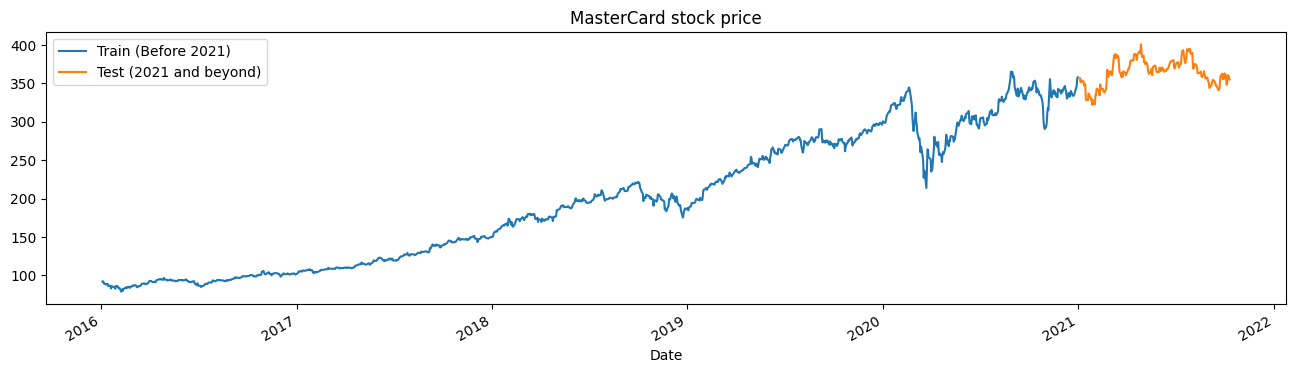

In [27]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

# Data Preprocessing

In [28]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [29]:
# Try using StandardScaler or any other scalar function
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).

For example, if the sequence is [1,2,3,4,5,6,7,8,9,10,11,12] and the n_step is three, then it will convert the sequence into three input timestamps and one output as shown below:

X	y
1,2,3	4
2,3,4	5
3,4,5	6
4,5,6	7
…	…

In [30]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model. The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

In [31]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [49]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=288, activation="elu", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

C:\Users\raknu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 288)            │       334,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,369 (1.28 MB)

 Trainable params: 334,369 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model_lstm.fit(X_train, y_train, epochs=60, batch_size=32)

Epoch 1/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.7455e-04
Epoch 2/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.7327e-04
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.7835e-04
Epoch 4/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 3.2479e-04
Epoch 5/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.5512e-04
Epoch 6/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.6405e-04
Epoch 7/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.3694e-04
Epoch 8/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.6738e-04
Epoch 9/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.7423e-04
Epoch 10/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.4912e-04
Epoch 11/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.5943e-04
Epoch 12/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.4285e-04
Epoch 13/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.1114e-04
Epoch 14/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.3762e-04
Epoch 15/60
38/

# Results

In [63]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
LSTM_predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [64]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


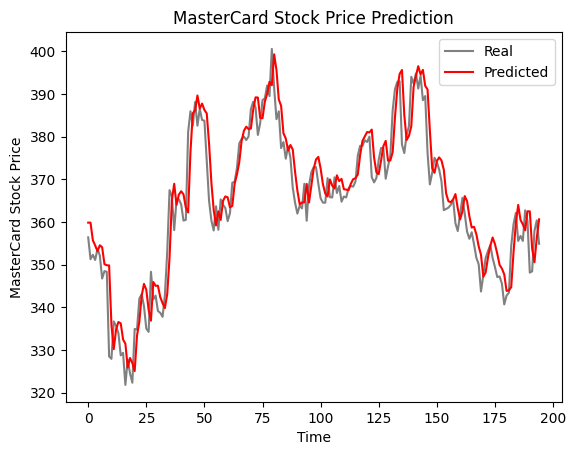

In [65]:
plot_predictions(test_set,LSTM_predicted_stock_price)

You have to train model to produce RMSE <= 6.35.


<=0.35 0.35 3.35 6.35 9.35 12.35
A      B+   B    C+   C    D+    D

In [66]:
return_rmse(test_set,LSTM_predicted_stock_price)

The root mean squared error is 5.90.


In [44]:
model_gru = Sequential()
model_gru.add(GRU(units=288, activation="elu", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

C:\Users\raknu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 288)            │       251,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,713 (983.25 KB)

 Trainable params: 251,713 (983.25 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model_gru.fit(X_train, y_train, epochs=60, batch_size=32)

Epoch 1/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0370
Epoch 2/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0022
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0011
Epoch 4/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014
Epoch 5/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 7.6237e-04
Epoch 6/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014
Epoch 7/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.9195e-04
Epoch 8/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.9329e-04
Epoch 9/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0010
Epoch 10/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 9.3174e-04
Epoch 11/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.9495e-04
Epoch 12/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 7.3072e-04
Epoch 13/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 6.2499e-04
Epoch 14/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 7.8489e-04
Epoch 15/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


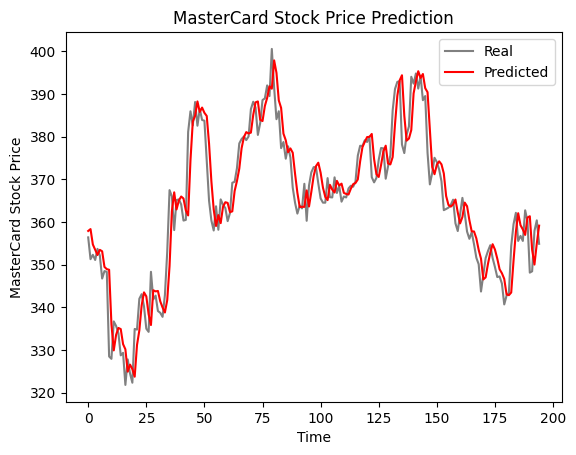

In [46]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

<=2.00 2.00 5.00 8.00 11.00 14.00
A      B+   B    C+   C     D+    D

In [47]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.75.


GRU RMSE: 5.748355739101181
LSTM RMSE: 5.898127232773422


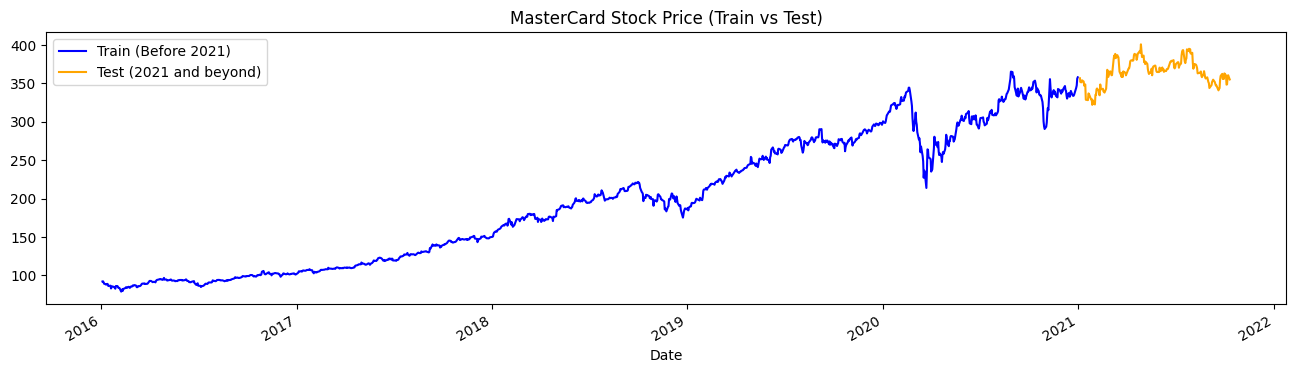

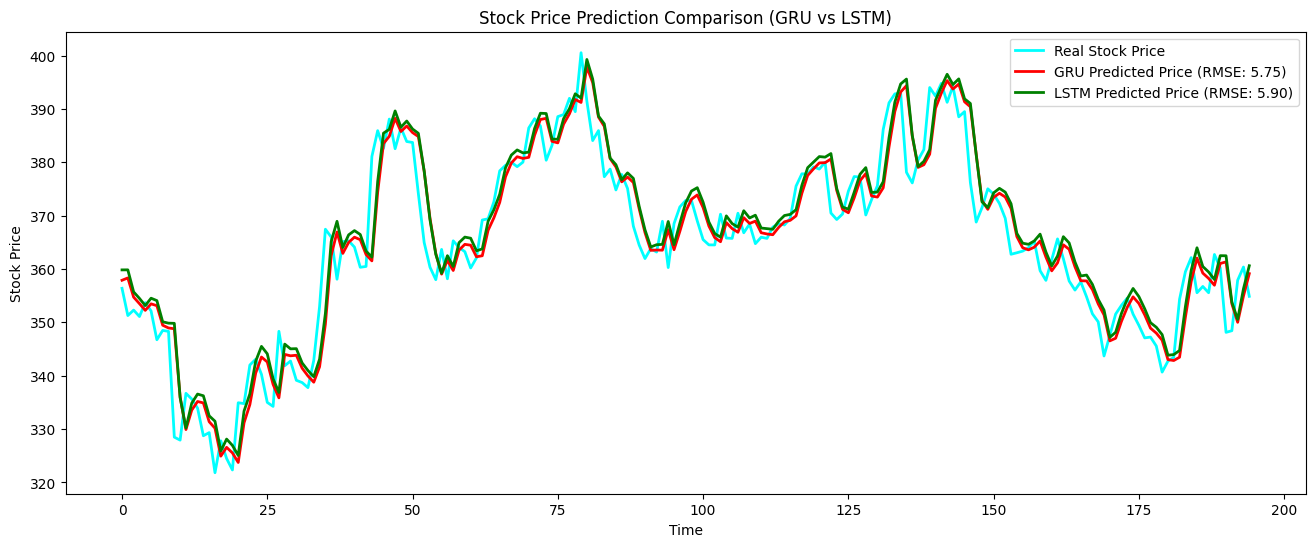

In [67]:
# สมมติว่ามีฟังก์ชัน return_rmse ถูกนิยามไว้แล้ว
def return_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))

# ฟังก์ชันสำหรับการสร้างกราฟเปรียบเทียบการทำนายจากหลายโมเดล
def plot_predictions(test_set, GRU_predicted, LSTM_predicted, rmse_gru, rmse_lstm):
    plt.figure(figsize=(16, 6))

    # กราฟราคาหุ้นจริง (ใช้สีฟ้า)
    plt.plot(test_set, color='cyan', label='Real Stock Price', linewidth=2)

    # กราฟการทำนายด้วย GRU (ใช้สีแดง)
    plt.plot(GRU_predicted, color='red', label=f'GRU Predicted Price (RMSE: {rmse_gru:.2f})', linewidth=2)

    # กราฟการทำนายด้วย LSTM (ใช้สีเขียว)
    plt.plot(LSTM_predicted, color='green', label=f'LSTM Predicted Price (RMSE: {rmse_lstm:.2f})', linewidth=2)

    # การตั้งค่ากราฟ
    plt.title('Stock Price Prediction Comparison (GRU vs LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# ฟังก์ชันสำหรับแสดงกราฟการแบ่งช่วง Train/Test
def train_test_plot(dataset, tstart, tend):
    plt.figure(figsize=(16, 4))
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(legend=True, label="Train", color="blue")
    dataset.loc[f"{tend+1}":, "High"].plot(legend=True, label="Test", color="orange")
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard Stock Price (Train vs Test)")
    plt.show()

# คำนวณค่า RMSE
rmse_gru = return_rmse(test_set, GRU_predicted_stock_price)
rmse_lstm = return_rmse(test_set, LSTM_predicted_stock_price)

# แสดงค่า RMSE สำหรับ GRU และ LSTM
print(f"GRU RMSE: {rmse_gru}")
print(f"LSTM RMSE: {rmse_lstm}")

# เรียกใช้ฟังก์ชันในการวาดกราฟ Train/Test
train_test_plot(dataset, tstart, tend)

# เรียกใช้ฟังก์ชันในการวาดกราฟเปรียบเทียบ GRU และ LSTM พร้อมแสดงค่า RMSE
plot_predictions(test_set, GRU_predicted_stock_price, LSTM_predicted_stock_price, rmse_gru, rmse_lstm)
